# Topic Modeling with LDA

This is like unsupervised learning (ie. clustering) for Natural Language Processing.

# Step 1: Loading Data

In [1]:
# Importing modules
import pandas as pd

# Read data into papers
papers = pd.read_csv('papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


# Step 2: Data Cleansing

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers

In [2]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
2101,2005,Non-iterative Estimation with Perturbed Gaussi...,Abstract Missing,Non-iterative Estimation with Perturbed\nGauss...
1554,2003,A Biologically Plausible Algorithm for Reinfor...,Abstract Missing,A Biologically Plausible Algorithm\nfor Reinfo...
968,2000,Rate-coded Restricted Boltzmann Machines for F...,Abstract Missing,Rate-coded Restricted Boltzmann Machines for\n...
4592,2013,Scalable kernels for graphs with continuous at...,While graphs with continuous node attributes a...,Scalable kernels for graphs with continuous at...
2407,2007,Invariant Common Spatial Patterns: Alleviating...,Abstract Missing,Invariant Common Spatial Patterns: Alleviating...


***Remove punctuation/lower casing***

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [3]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

2101    non-iterative estimation with perturbed\ngauss...
1554    a biologically plausible algorithm\nfor reinfo...
968     rate-coded restricted boltzmann machines for\n...
4592    scalable kernels for graphs with continuous at...
2407    invariant common spatial patterns: alleviating...
Name: paper_text_processed, dtype: object

# Step 3: Exploratory Analysis

To verify whether the preprocessing, we’ll make a simple word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

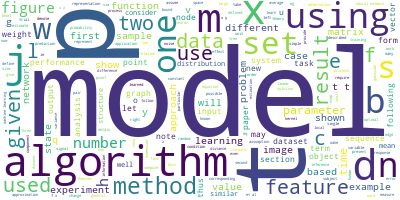

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# Step 4: Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [5]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

/usr/local/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christophermayorga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['non', 'iterative', 'estimation', 'perturbed', 'gaussian', 'markov', 'processes', 'yunsong', 'huang', 'keith', 'jenkins', 'signal', 'image', 'processing', 'institute', 'department', 'electrical', 'engineering', 'systems', 'university', 'southern', 'california', 'los', 'angeles', 'ca', 'yunsonghjenkins', 'sipiuscedu', 'abstract', 'develop', 'approach']


In [6]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 8), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2), (25, 1), (26, 3), (27, 1), (28, 2), (29, 1)]


# Step 5: LDA model training

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [7]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"model" + 0.004*"models" + 0.004*"algorithm" + 0.004*"two" + '
  '0.004*"data" + 0.004*"time" + 0.004*"figure" + 0.004*"learning" + '
  '0.003*"one" + 0.003*"set"'),
 (1,
  '0.005*"data" + 0.005*"model" + 0.005*"set" + 0.005*"using" + '
  '0.004*"learning" + 0.004*"algorithm" + 0.004*"two" + 0.004*"time" + '
  '0.004*"models" + 0.003*"matrix"'),
 (2,
  '0.008*"model" + 0.007*"learning" + 0.005*"algorithm" + 0.004*"data" + '
  '0.004*"features" + 0.004*"using" + 0.004*"set" + 0.004*"log" + 0.004*"time" '
  '+ 0.003*"function"'),
 (3,
  '0.006*"data" + 0.006*"algorithm" + 0.005*"model" + 0.005*"using" + '
  '0.005*"learning" + 0.004*"models" + 0.003*"time" + 0.003*"given" + '
  '0.003*"set" + 0.003*"one"'),
 (4,
  '0.006*"model" + 0.006*"time" + 0.004*"algorithm" + 0.004*"used" + '
  '0.004*"using" + 0.004*"one" + 0.004*"learning" + 0.003*"function" + '
  '0.003*"figure" + 0.003*"two"'),
 (5,
  '0.005*"model" + 0.005*"learning" + 0.005*"data" + 0.004*"time" + '
  '0.004*"al

# Step 6: Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.



In [8]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/usr/local/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


FileNotFoundError: [Errno 2] No such file or directory: './results/ldavis_prepared_10'

**Closing Notes**

Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this article addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

